# RAW Audio file with CSV Timestamps and Audio Clip Selection

In [ ]:
# Parameters
clip_duration = 60   # seconds
clip_delay = 5       # seconds after CSV time before clip starts


In [1]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import os
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
def get_start_time_from_filename(file_path: Path, 
                                 dt_format: str="%Y%m%d_%H%M%S") -> datetime:
    """
    Extracts the start time from the audio filename.
    Parameters:
    file_path (Path): The path to the audio file.
    dt_format (str): The datetime format used in the filename.
    Returns:
    datetime: The extracted start time as a datetime object.
    Raises:
    ValueError: If the filename does not match the expected format.
    """

    try:
        # Remove suffix and parse datetime from the stem
        dt = datetime.strptime(file_path.stem, dt_format)
    except ValueError:
        raise ValueError(
            f"Filename '{file_path.name}' does not match expected format 'YYYYMMDD_HHMMSS.WAV'."
        )
    return dt

def generate_time_axis(start_time: datetime, 
                       data: np.ndarray, samplerate: int) -> np.ndarray:
    """
    Generates a time axis for the audio data.
    Parameters:
    start_time (datetime): The start time of the audio recording.
    data (np.ndarray): The audio data array.
    samplerate (int): The sample rate of the audio data.
    Returns:
    np.ndarray: An array of datetime64 objects representing the time axis.
    """
    n_samples = data.shape[0]
    start_time = np.datetime64(start_time)
    time_axis = start_time + np.arange(n_samples) / samplerate * np.timedelta64(1, 's')

    # Test to make sure shapes match
    assert data.shape == time_axis.shape

    return time_axis

In [3]:
# Read CSV file with timestamps and durations
file_path = Path.cwd() / 'csv'
csv_files = [f for f in file_path.glob('*.csv')]
csv_files

[PosixPath('/home/dorian/Oslo-Wave-Tank-RAW-Data-Processing/csv/OsloWaveTankLog2D.csv')]

### Loading CSV File

In [4]:
# HACK: select the first CSV file found for processing in jupyter notebook
csv_file = csv_files[0]

# Rad CSV file
df = pd.read_csv(csv_file)

# Extract relevant columns
id = df['ID']
date = df['Date']
time_UTC = df['Time (ThinkPad DS) [UTC]']

# Convert date and time to datetime object with format YYYY-MM-DD HH:MM:SS
date_time_UTC = pd.to_datetime(date + ' ' + time_UTC, format='%Y-%m-%d %H:%M:%S')
date_time_UTC.head()

0   2025-10-29 11:22:00
1   2025-10-29 11:25:00
2   2025-10-29 11:27:00
3   2025-10-29 11:30:00
4   2025-10-29 11:45:00
dtype: datetime64[ns]

In [5]:
# Load all audio files
audio_path = Path.cwd() / 'input'
file_types = '*.WAV'  # the tuple of file types
audio_files = sorted([f for f in audio_path.glob(file_types)])



### Load Audio Data

In [6]:
# HACK: select the first audio file found for processing in jupyter notebook
audio_file = audio_files[0]

In [7]:
# Read audio file
samplerate, data = wav.read(audio_file)
data.shape, samplerate

# Determine audio recording duration
duration = 1e9 * data.shape[0] / samplerate # units: seconds [ns]

# Load Stat time from filename
start_time = get_start_time_from_filename(audio_file)

# Generate recording time axis
rec_times_axis = np.linspace(0, duration, len(data))

/tmp/ipykernel_56995/1736613767.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wav.read(audio_file)


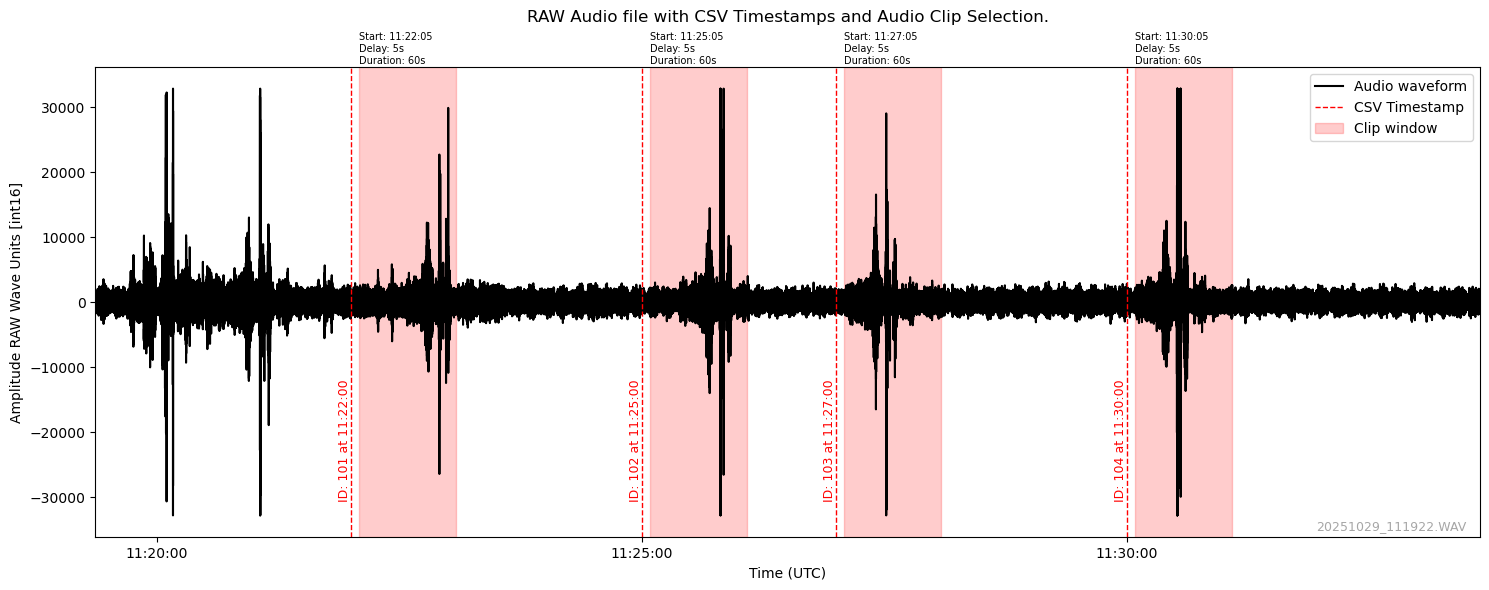

In [ ]:
# Downsample for plotting clarity
step = 100 # plot every 100th sample, decreases plotting time and file size
idx = np.arange(0, len(data), step)
time_axis = pd.to_datetime(start_time) + rec_times_axis[idx].astype('timedelta64[ns]')

# Determine audio start and end times
audio_start = time_axis[0]
audio_end   = time_axis[-1]

# Plot: only within audio range
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(time_axis, data[idx], label="Audio waveform", color='black')

for t, event_id in zip(date_time_UTC, df['ID']):
    # Skip if timestamp is completely outside audio file
    if t < audio_start or t > audio_end:
        continue

    # --- Red dashed vertical line at CSV timestamp ---
    ax.axvline(t, color='red', linestyle='--', linewidth=1, label='CSV Timestamp')

    # --- Annotate the ID near the top of the plot ---
    annotation_label = str(f"ID: {event_id} at {t.strftime('%H:%M:%S')}")
    ax.text(
        t,                      # x position (time)
        ax.get_ylim()[1] * -0.85, # y position (90% up the y-axis)
        annotation_label,          # the ID label
        rotation=90,            # vertical text
        color='red',
        fontsize=9,
        va='bottom',
        ha='right',
        backgroundcolor='none',
        alpha=1
    )

    # --- Shaded region (delayed clip window) ---
    start_t = t + pd.Timedelta(seconds=clip_delay)
    end_t = start_t + pd.Timedelta(seconds=clip_duration)

    if start_t > audio_end or end_t < audio_start:
        continue
    start_t = max(start_t, audio_start)
    end_t = min(end_t, audio_end)

    ax.axvspan(start_t, end_t, color='red', alpha=0.2, label=f'Clip window')
    annotation_label = str(f"Start: {start_t.strftime('%H:%M:%S')}\nDelay: {clip_delay}s\nDuration: {clip_duration}s")
    ax.text(
        start_t,                      # x position (time)
        ax.get_ylim()[1] * 1.01, # y position (90% up the y-axis)
        annotation_label,          # the ID label
        rotation=0,            # vertical text
        color='black',
        fontsize=7,
        va='bottom',
        ha='left',
        backgroundcolor='none',
        alpha=1
    )


# Restrict x-axis strictly to audio range
ax.set_xlim(audio_start, audio_end)

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())

# Annotation: Audio filename
ax.text(
    0.99, 0.01,                      # (x, y) in axes fraction coordinates
    audio_file.name,                 # the text
    transform=ax.transAxes,          # use axes-relative coordinates
    fontsize=9,
    color='gray',
    ha='right',                      # horizontal alignment
    va='bottom',                     # vertical alignment
    alpha=0.7,
)


# Formatting
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Amplitude RAW Wave Units [int16]")
ax.set_title(f"RAW Audio file with CSV Timestamps and Audio Clip Selection.", y=1.08)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.tight_layout()
plt.savefig(f"{audio_file.stem}_Audio_Clip_Selection.pdf", 
            dpi=72, bbox_inches='tight')
plt.show()
